In [1]:
import functools
import gzip
import itertools as it
import sys
import urllib.request
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Callable, Iterator, Optional, Set, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np

# Autodiff

In [2]:
Array = np.ndarray
BackpropFn = Callable[[Array], None]
TensorLike = Union["Tensor", Array, float]

@dataclass
class Tensor:
    value: Array
    grad: Optional[Array]
    backpropagate: Optional[BackpropFn]
    parents: Tuple["Tensor", ...]

    @property
    def requires_grad(self) -> bool:
        return self.grad is not None

    @classmethod
    def wrap(cls, value: TensorLike, requires_grad: bool) -> "Tensor":
        if isinstance(value, cls):
            return value
        value = np.array(value)
        return cls(
            value=value,
            grad=np.zeros_like(value) if requires_grad else None,
            backpropagate=None,
            parents=(),
        )

    def _dependency_order(self, visited: Set[int]) -> Iterator["Tensor"]:
        if id(self) not in visited:
            for parent in self.parents:
                yield from parent._dependency_order(visited)
            yield self
            visited.add(id(self))

    def backward(self) -> None:
        self.grad[...] = 1
        for tensor in reversed(list(self._dependency_order(set()))):
            if tensor.backpropagate is not None:
                tensor.backpropagate(tensor.grad)


def operation(fn: Callable[..., Tuple[Array, BackpropFn]]) -> Callable[..., Tensor]:
    @functools.wraps(fn)
    def wrapper(*args: TensorLike) -> Tensor:
        inputs = tuple(Tensor.wrap(arg, requires_grad=False) for arg in args)
        value, backpropagate = fn(*inputs)
        requires_grad = any(input.requires_grad for input in inputs)
        return Tensor(
            value=value,
            grad=np.zeros_like(value) if requires_grad else None,
            backpropagate=backpropagate if requires_grad else None,
            parents=inputs,
        )

    return wrapper

# Op definitions

In [3]:
class Op:
    @staticmethod
    @operation
    def matmul(x: Tensor, y: Tensor) -> Tuple[Array, BackpropFn]:
        def backpropagate(grad: Array) -> None:
            if x.requires_grad:
                x.grad += grad @ y.value.T
            if y.requires_grad:
                y.grad += x.value.T @ grad

        return x.value @ y.value, backpropagate

    @staticmethod
    @operation
    def add(*xs: Tensor) -> Tuple[Array, BackpropFn]:
        def backpropagate(grad: Array) -> None:
            for x in xs:
                if x.requires_grad:
                    x.grad += grad

        return sum(x.value for x in xs), backpropagate

    @staticmethod
    @operation
    def relu(x: Tensor) -> Tuple[Array, BackpropFn]:
        def backpropagate(grad: Array) -> None:
            x.grad += grad * (x.value > 0)

        return np.maximum(x.value, 0), backpropagate

    @staticmethod
    @operation
    def broadcast_to(x: Tensor, shape: Tensor) -> Tuple[Array, BackpropFn]:
        def backpropagate(grad: Array) -> None:
            assert not shape.requires_grad
            if x.requires_grad:
                x_shape = x.value.shape
                x_shape_pad = (1,) * (len(shape.value) - len(x_shape)) + x_shape
                (sum_dims,) = np.where(np.array(x_shape_pad) == 1)
                x.grad += np.sum(grad, axis=tuple(sum_dims), keepdims=True).reshape(
                    x_shape
                )

        return np.broadcast_to(x.value, shape.value), backpropagate

    @staticmethod
    @operation
    def softmax_cross_entropy(x: Tensor, targets: Tensor) -> Tuple[Array, BackpropFn]:
        assert x.value.ndim == 2
        assert targets.value.shape == x.value.shape[:1]
        x_shift = x.value - x.value.max(axis=1, keepdims=True)
        logp = x_shift - np.log(np.sum(np.exp(x_shift), axis=1, keepdims=True))

        def backpropagate(grad: Array) -> None:
            assert not targets.requires_grad
            if x.requires_grad:
                scaled_grad = grad / targets.value.size
                x.grad[np.arange(targets.value.size), targets.value] -= scaled_grad
                x.grad += scaled_grad * np.exp(logp)

        loss = -np.mean(logp[np.arange(targets.value.size), targets.value])
        return loss, backpropagate

# Model & optimiser

In [4]:
class Model:
    def __init__(self):
        random = np.random.RandomState(3721)
        self.parameters = []
        self.lr = 0.1
        self.W0 = self.parameter(random.randn(28 * 28, 256) / np.sqrt(28 * 28))
        self.b0 = self.parameter(np.zeros(256))
        self.W1 = self.parameter(random.randn(256, 10) / np.sqrt(256))
        self.b1 = self.parameter(np.zeros(10))

    def parameter(self, value: Array) -> Tensor:
        tensor = Tensor.wrap(value.astype(np.float32), requires_grad=True)
        self.parameters.append(tensor)
        return tensor

    def step(self, x: Array, y: Array) -> float:
        for parameter in self.parameters:
            parameter.grad[...] = 0
        h = Op.matmul(x, self.W0)
        h = Op.add(h, Op.broadcast_to(self.b0, h.value.shape))
        h = Op.relu(h)
        h = Op.matmul(h, self.W1)
        h = Op.add(h, Op.broadcast_to(self.b1, h.value.shape))
        loss = Op.softmax_cross_entropy(h, y)
        loss.backward()
        for parameter in self.parameters:
            parameter.value -= self.lr * parameter.grad
        return float(loss.value)

# Training

0.20006069823168218


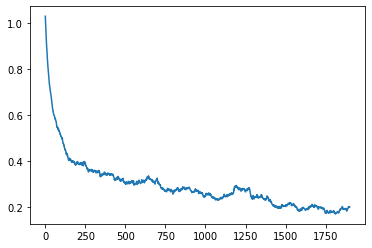

In [5]:
def mnist_batches(batch_size: int) -> Iterator[Tuple[Array, Array]]:
    # Download & read dataset
    data_dir = Path("data/mnist")
    data_dir.mkdir(parents=True, exist_ok=True)

    def _load(url: str, name: str, offset: int) -> Array:
        dest = data_dir / name
        if not dest.exists():
            print(f"Downloading {url} -> {dest}", file=sys.stderr)
            with urllib.request.urlopen(url) as f:
                dest.write_bytes(f.read())
        with gzip.open(dest) as f:
            return np.frombuffer(f.read()[offset:], dtype=np.uint8)

    images_url = "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz"
    images = (
        _load(images_url, "images.gz", offset=16).reshape(-1, 28, 28).astype(np.float32)
        / 255
    )
    labels_url = "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"
    labels = _load(labels_url, "labels.gz", offset=8)

    # Yield batches
    random = np.random.RandomState(9741)
    while True:
        indices = np.arange(len(images))
        random.shuffle(indices)
        for offset in range(0, len(images) - batch_size + 1, batch_size):
            batch = indices[offset : offset + batch_size]
            yield images[batch], labels[batch]


model = Model()
losses = []
for batch_x, batch_y in it.islice(mnist_batches(batch_size=16), 2000):
    losses.append(model.step(batch_x.reshape(batch_x.shape[0], -1), batch_y))
plt.plot(np.convolve(losses, np.full(100, 1 / 100), mode="valid"))
print(np.mean(losses[-100:]))